In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from bi_tools.score_card import create_score

warnings.filterwarnings('ignore')

In [2]:
"""
物资分类：
数据集：物料数据 material_group2.xlsx
包含风险相关的24个指标
和重要性相关的9个指标
1）使用逻辑回归进行建模
四种分类：战略、瓶颈、一般、杠杆
2）绘制Kraljic矩阵

"""
#加载数据
df = pd.read_csv('material_group.csv')
df

,material_code,material_name,risk1,risk2,risk3,risk4,risk5,risk6,risk7,risk8,...,money4,money5,money6,money7,money8,money9,risk_label,money_label,risk_score,money_score
0,1,材料组1,635,661,6,647,376,35,905,984,...,604,299,208,191,338,476,0,0,10856,4234
1,2,材料组2,210,323,579,775,830,21,623,756,...,67,566,164,11,193,310,1,0,12037,2227
2,3,材料组3,304,394,469,626,194,67,814,644,...,883,985,604,729,810,788,0,1,10112,5904
3,4,材料组4,561,291,264,939,615,863,377,943,...,566,604,826,457,897,249,0,0,11319,4219
4,5,材料组5,297,483,635,82,632,759,202,18,...,847,455,336,864,526,384,0,1,10800,5160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,材料组996,609,96,295,129,455,388,691,613,...,616,14,566,93,298,790,1,0,12027,3617
996,997,材料组997,638,724,41,636,306,88,927,89,...,373,110,577,332,970,88,0,0,11616,3747
997,998,材料组998,827,121,273,694,23,471,799,264,...,505,155,661,307,238,645,0,1,11015,4883
998,999,材料组999,455,650,312,202,260,230,698,28,...,707,340,516,872,674,546,0,1,11036,5803


In [3]:
#分别获取risk和money的标签和数据
risk_columns = ['risk' + str(x) for x in range(1,25)]
# print(risk_columns)
money_columns = ['money' + str(x) for x in range(1,10)]
# print(money_columns)

x_risk = df[risk_columns]
y_risk = df['risk_label']
x_money = df[money_columns]
y_money = df['money_label']

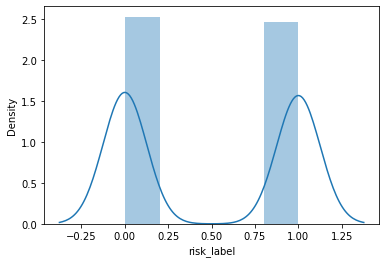

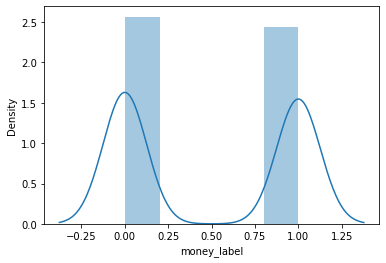

In [4]:
#查看标签分布
sns.distplot(y_risk)
plt.show()
sns.distplot(y_money)
plt.show()

In [5]:
#数据集切分
from sklearn.model_selection import train_test_split

SEED = 33
x_risk_train,x_risk_test,y_risk_train,y_risk_test = train_test_split(x_risk,y_risk,test_size = 0.2,random_state = SEED)
x_money_train,x_money_test,y_money_train,y_money_test = train_test_split(x_money,y_money,test_size = 0.2,random_state = SEED)

In [6]:
#数据规范化
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
x_risk_train = ss.fit_transform(x_risk_train)
x_risk_test = ss.transform(x_risk_test)
x_money_train = ss.fit_transform(x_money_train)
x_money_test = ss.transform(x_money_test)

In [7]:
#使用逻辑回归进行分类
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_model(model,x_train,y_train,x_test,y_test,task):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)
    score = accuracy_score(y_test,y_pred)
    print('{}使用{}预测的accuracy_rate：{}'.format(task,model,score))    

model = LogisticRegression()
#risk预测
train_model(model,x_risk_train,y_risk_train,x_risk_test,y_risk_test,'risk')
#money预测
train_model(model,x_money_train,y_money_train,x_money_test,y_money_test,'money') 

risk使用LogisticRegression()预测的accuracy_rate：0.9
money使用LogisticRegression()预测的accuracy_rate：0.935


In [8]:
#对模型进行交叉评估
from sklearn.model_selection import cross_val_score

def cross_val(model,x_train,y_train,task,cv = 5,scoring = 'accuracy'):
    score = cross_val_score(model,x_train,y_train,cv=cv,scoring=scoring).mean()   
    print('{}使用{}预测的{}：{}'.format(task,model,scoring,score))
    
#risk交叉验证
cross_val(model,x_risk_train,y_risk_train,'risk')
#money交叉验证
cross_val(model,x_money_train,y_money_train,'money')

risk使用LogisticRegression()预测的accuracy：0.8949999999999999
money使用LogisticRegression()预测的accuracy：0.9225


In [9]:
#对逻辑回归超参数调整
def lr_risk_cv(C,max_iter):
    model = LogisticRegression(C = C,max_iter = max_iter)
    score = cross_val_score(model,x_risk_train,y_risk_train,cv =5,scoring = 'accuracy').mean()
    return score

def lr_money_cv(C,max_iter):
    model = LogisticRegression(C = C,max_iter = max_iter)
    score = cross_val_score(model,x_money_train,y_money_train,cv =5,scoring = 'accuracy').mean()
    return score

In [10]:
#贝叶斯超参数优化
from bayes_opt import BayesianOptimization

def bayes_optimize(function,pbounds):
    optimizor = BayesianOptimization(f = function,pbounds = pbounds)
    optimizor.maximize()
    return optimizor.max    

In [11]:
#优化边界设置
pbounds = {"C":(0.1,10),
         "max_iter":(50,500),
         }
#risk
#lr_risk_best_params = bayes_optimize(lr_risk_cv,pbounds)
#print(lr_risk_best_params)
#money
#lr_money_best_params = bayes_optimize(lr_money_cv,pbounds)
#print(lr_risk_best_params)

In [12]:
#使用grid_search_cv优化参数
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

estimator = LogisticRegression()
param_grid = {"C":(0.1,1,5,10),
         "max_iter":(50,100,200,300,400,500),
         }

gs = GridSearchCV(estimator = LogisticRegression(),param_grid = param_grid,scoring = 'accuracy',cv =5,verbose =10,n_jobs=-1)

In [13]:
#risk调参
gs.fit(x_risk_train,y_risk_train)
print(gs.best_params_)
y_risk_pred = gs.best_estimator_.predict(x_risk_test)
print(classification_report(y_risk_test,y_risk_pred))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    2.5s


{'C': 0.1, 'max_iter': 50}
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       106
           1       0.88      0.91      0.90        94

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1928s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  89 out of 120 | elapsed:    2.7s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done 102 out of 120 | elapsed:    2.7s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    2.7s finished


In [14]:
#money调参
gs.fit(x_money_train,y_money_train)
print(gs.best_params_)
y_money_pred = gs.best_estimator_.predict(x_money_test)
print(classification_report(y_money_test,y_money_pred))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Batch computation too fast (0.0375s.) Setting batch_size=10.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  11 out of 120 | elapsed:    0.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  24 out of 120 | elapsed:    0.1s remaining:    0.7s


{'C': 5, 'max_iter': 50}
              precision    recall  f1-score   support

           0       0.94      0.91      0.93        93
           1       0.93      0.95      0.94       107

    accuracy                           0.94       200
   macro avg       0.94      0.93      0.93       200
weighted avg       0.94      0.94      0.93       200



[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.2s finished


In [15]:
#得到risk评分
scored_risk_df = create_score(x_risk,y_risk)
scored_risk_df

LR模型的评估：
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       106
           1       0.72      0.81      0.76        94

    accuracy                           0.76       200
   macro avg       0.76      0.76      0.76       200
weighted avg       0.77      0.76      0.76       200



,risk3,risk4,risk6,risk8,risk10,risk11,risk13,risk20,risk21,risk24,target,score
0,6,647,35,984,509,35,178,656,436,409,0,705
1,579,775,21,756,392,613,650,267,886,907,1,568
2,469,626,67,644,221,318,853,201,514,499,0,662
3,264,939,863,943,804,721,328,838,278,639,0,520
4,635,82,759,18,240,872,173,169,653,495,0,734
...,...,...,...,...,...,...,...,...,...,...,...,...
995,295,129,388,613,35,615,305,676,373,826,1,709
996,41,636,88,89,549,227,588,904,583,284,0,699
997,273,694,471,264,710,869,229,662,225,385,0,643
998,312,202,230,28,199,816,545,379,332,866,0,739


In [16]:
#得到money评分
scored_money_df = create_score(x_money,y_money)
scored_money_df

LR模型的评估：
              precision    recall  f1-score   support

           0       0.89      0.88      0.89        93
           1       0.90      0.91      0.90       107

    accuracy                           0.90       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.90      0.89       200



,money1,money2,money3,money4,money5,money6,money7,money8,money9,target,score
0,900,813,405,604,299,208,191,338,476,0,714
1,189,271,456,67,566,164,11,193,310,0,1121
2,45,566,494,883,985,604,729,810,788,1,380
3,229,13,378,566,604,826,457,897,249,0,654
4,636,981,131,847,455,336,864,526,384,1,551
...,...,...,...,...,...,...,...,...,...,...,...
995,122,175,943,616,14,566,93,298,790,0,867
996,410,638,249,373,110,577,332,970,88,0,895
997,769,719,884,505,155,661,307,238,645,1,522
998,494,926,728,707,340,516,872,674,546,1,427


In [17]:
print(scored_risk_df['score'].max())
print()

904



In [18]:
def plot_kraljic_matrix(money_data,risk_data):
    """
    根据风险和金额评分生成kraljic矩阵
    """
    #准备数据
    x_mean = money_data['score'].mean()
    y_mean = risk_data['score'].mean()
    df = money_data[['score']]
    df.columns = ['money_score']
    df['risk_score'] = risk_data[['score']]
    #print(df)
    df_strategy = df[df['money_score']> x_mean][df['risk_score'] > y_mean]
    df_neck = df[df['money_score']<= x_mean][df['risk_score'] > y_mean]
    df_level = df[df['money_score']>x_mean][df['risk_score']<= y_mean]
    df_normal = df[df['money_score']<= x_mean][df['risk_score']<= y_mean]
    #print(df_strategy)
    
    #设置图框和字体
    plt.figure(figsize =(12,8))
    plt.rcParams['font.sans-serif'] = [u'simHei']
    plt.rcParams['font.size'] =16
    #绘制散点图    
    plt.scatter(x = df_strategy['money_score'],y = df_strategy['risk_score'],s=50,c='r',marker='x',label='战略')
    plt.scatter(x = df_neck['money_score'],y= df_neck['risk_score'],s=50,c='b',marker = 'o',label = '瓶颈')
    plt.scatter(x = df_level['money_score'],y = df_level['risk_score'],s=50,c='y',marker = 'v',label = '杠杆')
    plt.scatter(x = df_normal['money_score'],y= df_normal['risk_score'],s=50,c='k',marker ='^',label ='一般')
    #绘制分割线
    plt.hlines(y_mean,money_data['score'].min(),money_data['score'].max(),color = 'orange')
    plt.vlines(x_mean,risk_data['score'].min(),risk_data['score'].max(),color = 'orange')
    #设置标题和坐标轴
    plt.title('material group Kraljic matrix')
    plt.xlabel('Purchase Amount Score')
    plt.ylabel('Supply Risk Score')
    plt.legend()
    plt.show()
    

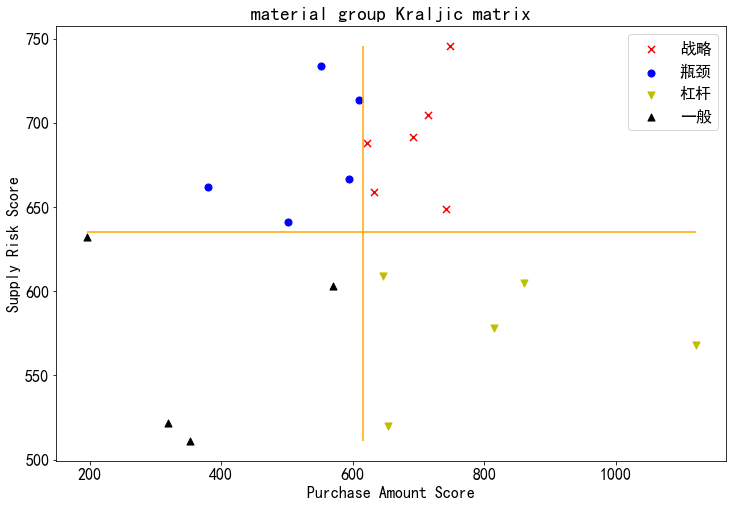

In [19]:
plot_kraljic_matrix(scored_money_df[:20],scored_risk_df[:20])